In [0]:
from fastai import *
from fastai.vision import *
from torchvision.models import *

In [0]:
%%capture
# upzipping lenses.zip from google drive
!unzip "/content/drive/My Drive/lenses.zip"

In [0]:
# defining datapath
path = Path('/content/lenses') # Define path to the image folders

# creating a dataloader and applying transforms (augmentation to increase the test/valid size)
data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.1,    #validation set will be 10% of total dataset
                                  ds_tfms=get_transforms(do_flip=True,      
                                                         #horizontal flips enabled

                                                         flip_vert=True,    
                                                         #vertical flips enabled

                                                         max_rotate=90.0,   
                                                         #max rotation of 90%

                                                         p_affine=0.05,     
                                                         #probability of applying a symmetric warp

                                                         p_lighting=0.05),  
                                                        #probability of applying lighting effects if defined
                                  
                                  size=(128,128),   
                                  # image resizing to get a constant size for all images
                                  
                                  resize_method=ResizeMethod.SQUISH,
                                  num_workers=4, 
                                  bs = 128) \       # batch size of 128
                                .normalize(imagenet_stats)

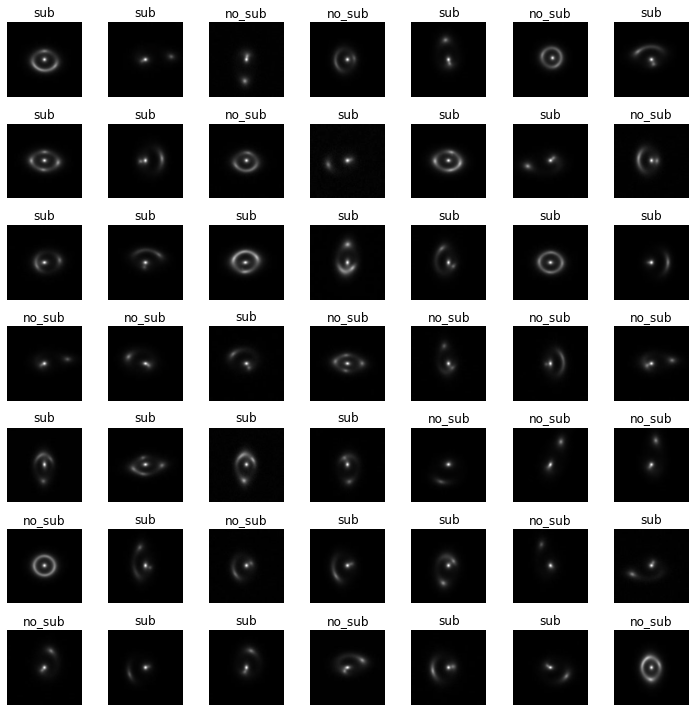

In [0]:
# visualisation of images in dataloader
data.show_batch(rows=7, figsize=(10, 10))

In [0]:
# creating a learner object (model) - pretrained resnet 152 which will be finetuned for this particular task

arch = resnet152 
def getLearner():
    return create_cnn(data, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learn = getLearner()

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.054633,0.752480,0.646000,02:04
1,0.943923,0.661629,0.670000,01:54
2,0.791252,0.592936,0.697000,01:54
3,0.666916,0.520321,0.731000,01:53
4,0.563786,0.436201,0.779000,01:53
5,0.491482,0.353403,0.824000,01:53
6,0.413811,0.317007,0.846000,01:53
7,0.332543,0.219474,0.897000,01:53
8,0.277281,0.165743,0.924000,01:53
9,0.223933,0.185692,0.925000,01:53


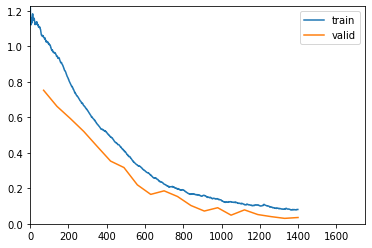

In [0]:
# running for 25 epochs with auto-stop in case of overfitting

learn.fit_one_cycle(25)

In [0]:
# learning was autocut on the 20th epoch.


# saving the .pth and .pkl files in the working directory
learn.export()
learn.save('version_1')

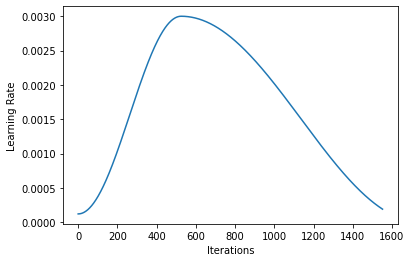

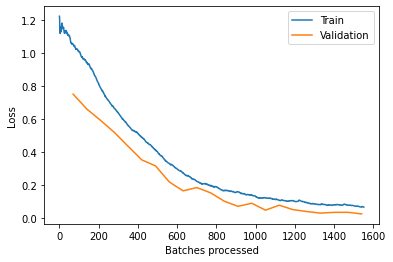

In [8]:
''' visualising the
    - variable learning rate
    - loss over iterations / batch iterations
'''

learn.recorder.plot_lr()
learn.recorder.plot_losses()

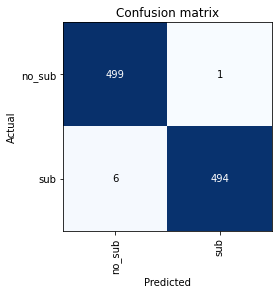

In [9]:
# Confusion matrix (showing excellent immunity for false positives and negatives)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [11]:
# the detailed model architecture

learn.load('version_1')

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
sub,sub,sub,sub,sub
Path: /content/lenses;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
sub,no_sub,sub,sub,no_sub
Path: /content/lenses;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [12]:
preds,y, loss = learn.get_preds(with_loss=True)

# get accuracy
acc = accuracy(preds, y)

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)

In [13]:
# displaying the Model Accuracy and Area under the Curve

print('The accuracy is {0} %.'.format(acc))
print('ROC area is {0}'.format(roc_auc))

The accuracy is 0.9929999709129333 %.
ROC area is 0.9996280000000001


No handles with labels found to put in legend.


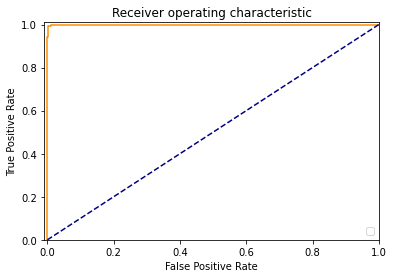

In [14]:
# plotting the AUROC (Area under ROC) graph

plt.figure()

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

In [0]:
learn.export()
learner = load_learner("/content/", test=ImageList.from_folder("/content/lenses"))

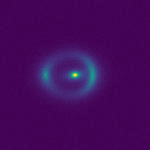

In [25]:
# visualising an image from the dataset by passing its index

il = ImageList.from_folder("/content/lenses")
il.convert_mode = 'L'
il.open(il.items[1006])

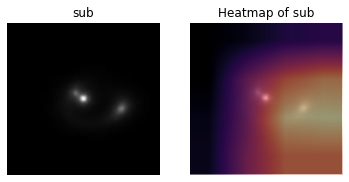

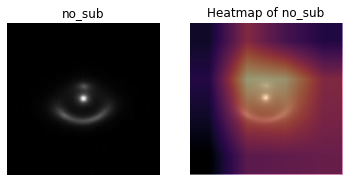

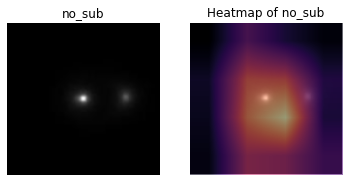

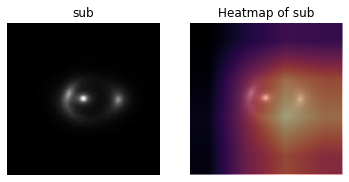

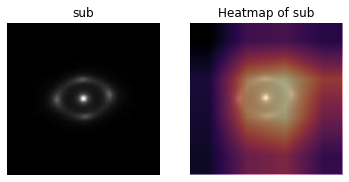

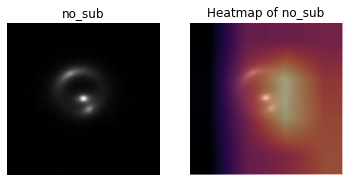

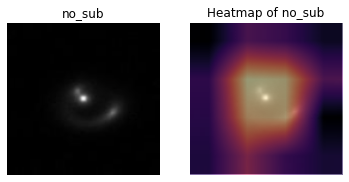

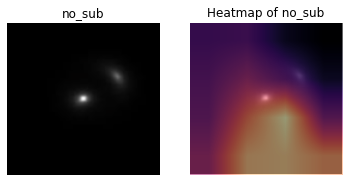

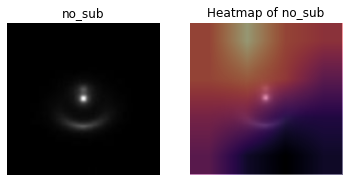

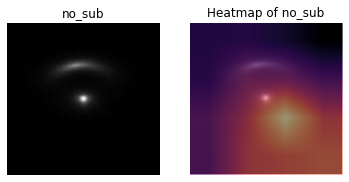

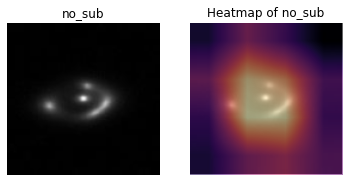

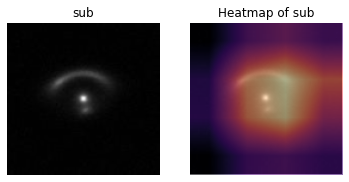

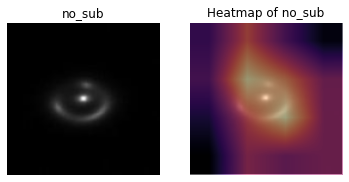

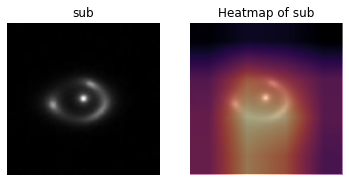

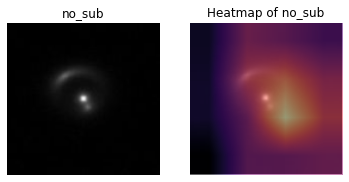

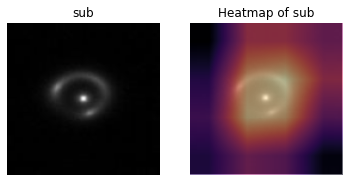

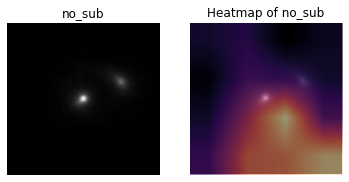

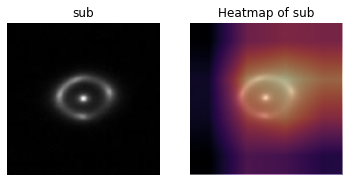

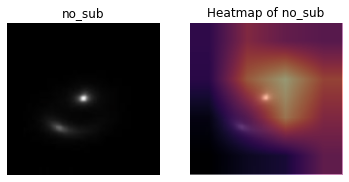

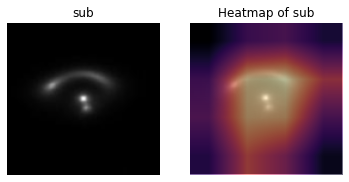

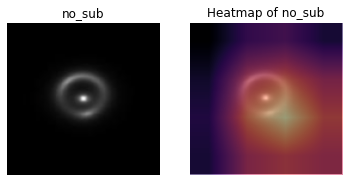

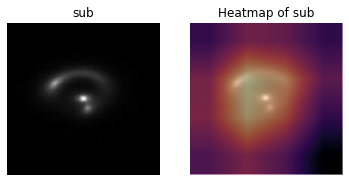

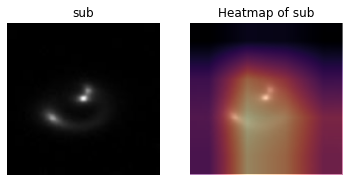

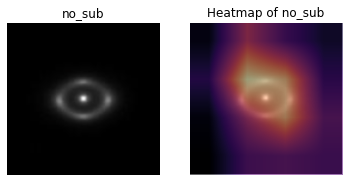

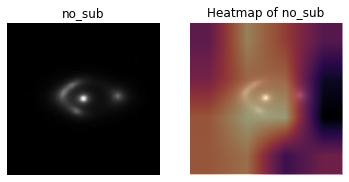

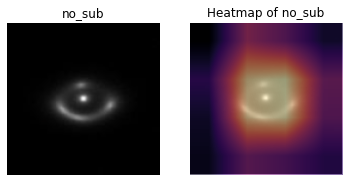

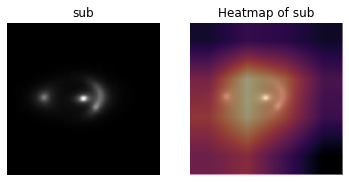

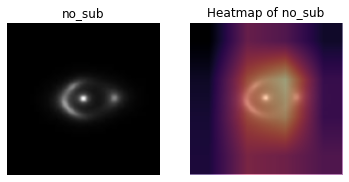

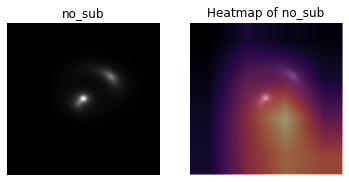

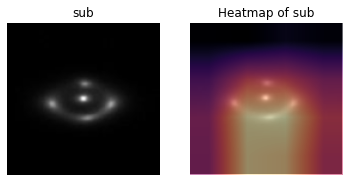

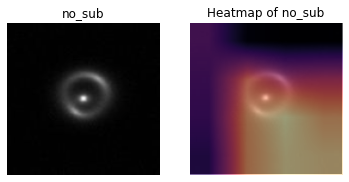

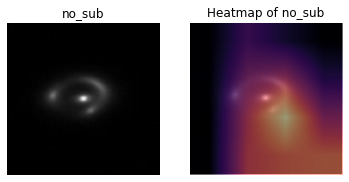

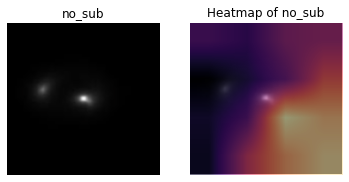

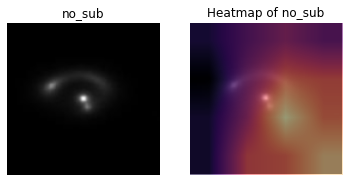

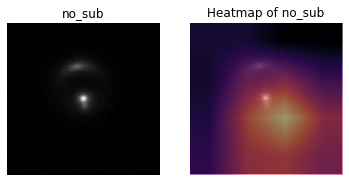

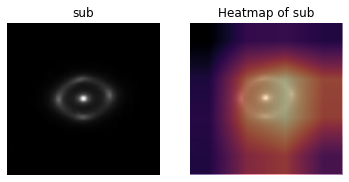

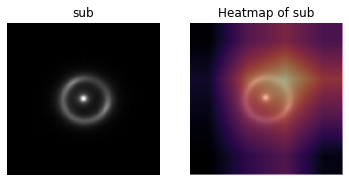

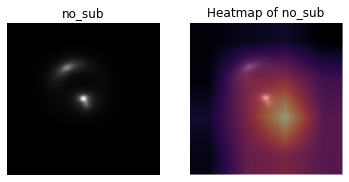

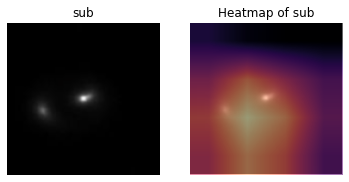

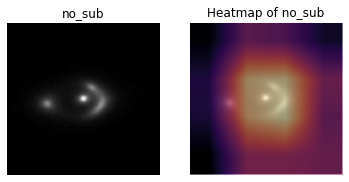

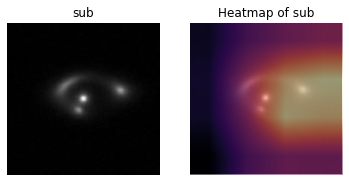

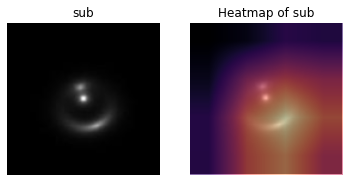

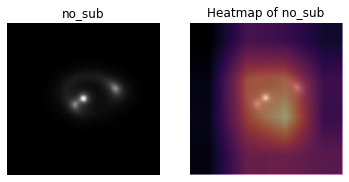

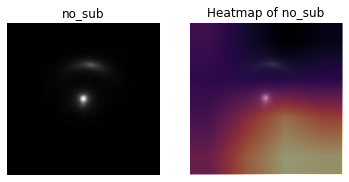

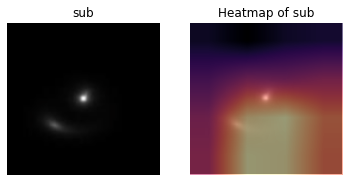

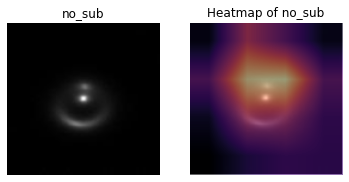

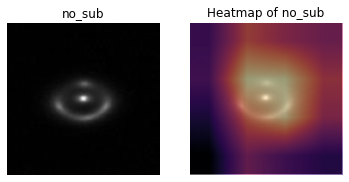

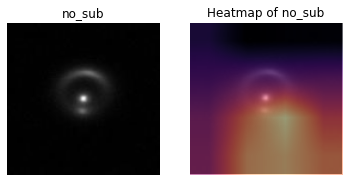

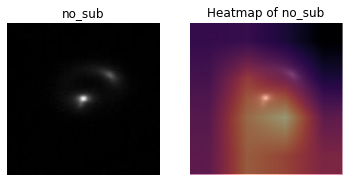

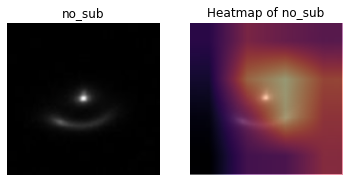

In [29]:
# callback implemented to view the areas of the image that triggered the classifier as a heatmap

from fastai.callbacks.hooks import *

def visualize_cnn_by_heatmap(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'Heatmap of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(70, 120):
    visualize_cnn_by_heatmap(learn, idx)

In [27]:
# GPU information from Google Colab

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Mar 18 12:42:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    74W / 149W |   9102MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

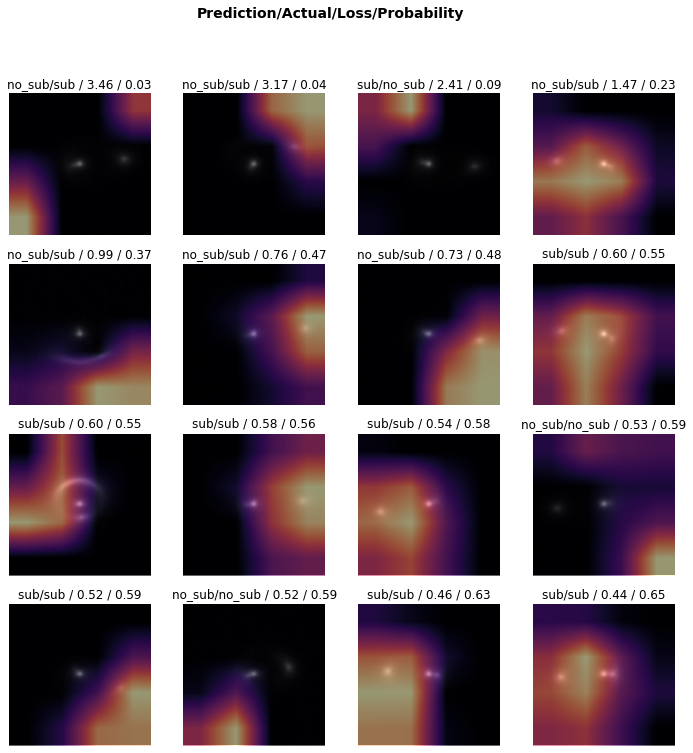

In [10]:
# plotting the top losses for further improvement analysis

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(16,heatmap=True)